In [ ]:
!git clone https://github.com/ECON-470-Data-Sci-Econ-Social-Issues/PSM_ML.git

fatal: destination path 'PSM_ML' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/PSM_ML/Formatted_data.csv')

needed_columns = ['teamname', 'year', 'seasonwins', 'alumni_ops_athletics', 'alum_non_athl_ops',
                  'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new',
                  'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate',
                  'sat_25', 'seasongames']
df = df[needed_columns]

In [ ]:
# Create lagged variables
for lag in range(1, 11):
    df[f'lag_seasonwins{lag}'] = df.groupby('teamname')['seasonwins'].shift(lag)

# Define the treatment variable
df['treated'] = (df['seasonwins'] > df['seasonwins'].median()).astype(int)

# Covariates for the model
covariates = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
              'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
              'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25'] + \
              [f'lag_seasonwins{i}' for i in range(1, 11)]

# Scaling and imputation
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[covariates].astype(float))
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_scaled)
df_imputed = pd.DataFrame(df_imputed, columns=covariates)

# Adjusting RandomForest parameters to control for overfitting
rf_classifier = RandomForestClassifier(
    n_estimators=50,         # Reduced number of trees
    max_depth=5,             # Limiting depth of each tree
    min_samples_leaf=10,     # More samples at each leaf
    min_samples_split=20,    # More samples required to split a node
    random_state=42          # For reproducibility
)
rf_classifier.fit(df_imputed, df['treated'])
df['propensity_score_rf'] = rf_classifier.predict_proba(df_imputed)[:, 1]

# Use KNN for matching based on Random Forest propensity scores
control = df[df['treated'] == 0]
treated = df[df['treated'] == 1]
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score_rf']])
distances, indices = nn.kneighbors(treated[['propensity_score_rf']])
matched_control = control.iloc[indices.flatten()]
matched_data = pd.concat([treated, matched_control])


# Matching using Random Forest propensity scores
nn_rf = NearestNeighbors(n_neighbors=1, metric='euclidean')
control_rf = df[df['treated'] == 0]
treated_rf = df[df['treated'] == 1]
nn_rf.fit(control_rf[['propensity_score_rf']])
distances_rf, indices_rf = nn_rf.kneighbors(treated_rf[['propensity_score_rf']])
matched_control_rf = control_rf.iloc[indices_rf.flatten()]
matched_data_rf = pd.concat([treated_rf, matched_control_rf])

In [ ]:
#This was test code to look at how not using Random Forests would impact our outcomes (if you uncomment it will mess up downstream code unless you replace propensityscore to not be using rf)
# # Logistic Regression for Propensity Score Calculation
# logit_model = LogisticRegression(max_iter=1000, solver='liblinear')
# logit_model.fit(df_imputed, df['treated'])
# df['propensity_score_logit'] = logit_model.predict_proba(df_imputed)[:, 1]

# # Matching using Logistic Regression propensity scores
# nn_logit = NearestNeighbors(n_neighbors=1, metric='euclidean')
# control_logit = df[df['treated'] == 0]
# treated_logit = df[df['treated'] == 1]
# nn_logit.fit(control_logit[['propensity_score_logit']])
# distances_logit, indices_logit = nn_logit.kneighbors(treated_logit[['propensity_score_logit']])
# matched_control_logit = control_logit.iloc[indices_logit.flatten()]
# matched_data_logit = pd.concat([treated_logit, matched_control_logit])
# # Evaluate the logistic regression model
# print("Logistic Regression R^2 Score:", logit_model.score(df_imputed, df['treated']))  # Accuracy, not R²
# print("Confusion Matrix:\n", confusion_matrix(df['treated'], logit_model.predict(df_imputed)))
# print("Classification Report:\n", classification_report(df['treated'], logit_model.predict(df_imputed)))

Best alpha: 0.036847569365992094
Best l1 ratio: 1.0
Elastic Net Coefficients: [ 0.18576182 -0.         -0.          0.          0.          0.
  0.          0.01650174  0.00658956  0.          1.0696271   0.16972904
  0.23789869  0.13959495  0.14195459  0.          0.00536558 -0.
  0.17327802  0.        ]
Elastic Net Intercept: 5.405700733996707


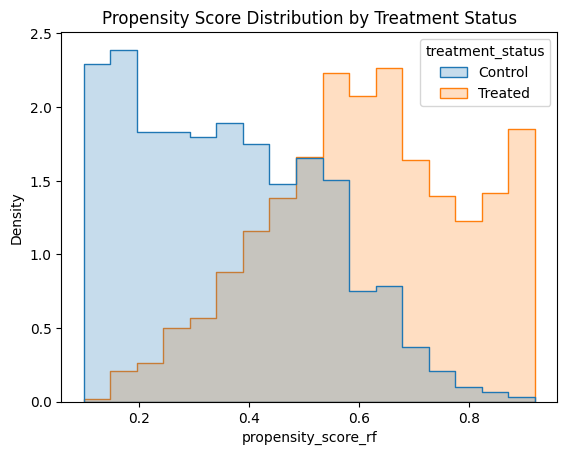

In [ ]:

# Elastic Net Model
elastic_net = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
elastic_net.fit(df_imputed, df['seasonwins'])  # Assume df['seasonwins'] is available correctly
print(f"Best alpha: {elastic_net.alpha_}")
print(f"Best l1 ratio: {elastic_net.l1_ratio_}")
print(f"Elastic Net Coefficients: {elastic_net.coef_}")
print(f"Elastic Net Intercept: {elastic_net.intercept_}")

# Perform nearest neighbor matching
control = df[df['treated'] == 0]
treated = df[df['treated'] == 1]
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score_rf']])
distances, indices = nn.kneighbors(treated[['propensity_score_rf']])
matched_control = control.iloc[indices.flatten()]

# Create a matched dataset
matched_data = pd.concat([treated, matched_control])

# Proceed with your analysis on matched_data
X_matched = matched_data[covariates + ['propensity_score_rf']]
y_matched = matched_data['seasonwins']

# Scale data before imputation
scaler = StandardScaler()
X_matched_scaled = scaler.fit_transform(X_matched)
X_matched_scaled = pd.DataFrame(X_matched_scaled, columns=covariates + ['propensity_score_rf'])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_matched_imputed = imputer.fit_transform(X_matched_scaled)
X_matched_imputed = pd.DataFrame(X_matched_imputed, columns=covariates + ['propensity_score_rf'])

# Replace old values with imputed values in matched data
matched_data[covariates + ['propensity_score_rf']] = X_matched_imputed

df['treatment_status'] = df['treated'].map({0: 'Control', 1: 'Treated'})

# Plotting
sns.histplot(data=df, x='propensity_score_rf', hue='treatment_status', element='step', stat='density', common_norm=False)
plt.title('Propensity Score Distribution by Treatment Status')
plt.savefig('propensity_score_rf_distribution.png')

In [ ]:
# Make sure the 'covariates' list is correctly specified
covariates.append('propensity_score_rf')  # Only append if it's not already included

print("Covariates used for imputation:", covariates)

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(df[covariates])  # Apply KNN imputation
X_imputed = pd.DataFrame(X_imputed, columns=covariates)  # Ensure the columns match

# Replace the old data with the imputed data in your DataFrame
if len(df.columns.intersection(covariates)) == len(covariates):
    df[covariates] = X_imputed
else:
    raise ValueError("Mismatch in DataFrame columns and covariates")

# Define your features and target variable
X = df[covariates]
y = df['seasonwins']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Random Forest Mean Squared Error:", mse)

print(df)

varlist = [
    'alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
    'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
    'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25' , 'seasongames', 'seasonwins'
]

# Create lagged variables for each needed column including 'seasonwins' and 'seasongames'
lags = [1, 2, 3]
for col in needed_columns:
    if col not in ['teamname', 'year']:
        for lag in lags:
            df[f'lag{lag}_{col}'] = df.groupby('teamname')[col].shift(lag)

df['weight'] = np.where(df['treated'] == 1,
                        1 / df['propensity_score_rf'],
                        1 / (1 - df['propensity_score_rf']))


for var in varlist:
    df[f'r{var}'] = df[var] - df[f'lag2_{var}']

df.to_csv('ML_lag_variable_check.csv')
# Proceed with your regression analysis as previously coded
# Initialize DataFrame to store results, etc.
results_df = pd.DataFrame()

counter = 1

for varname in varlist:
    formula_wls = f"r{varname} ~ rseasonwins + lag_seasonwins3 + lag1_seasongames + lag3_seasongames + year + propensity_score_rf"
    try:
        wls_model = smf.wls(formula=formula_wls, data=df, weights=df['weight']).fit()
        print(f"WLS Model Summary for {varname}:")
        print(wls_model.summary())

    except Exception as e:
        print(f"Failed to fit WLS model for {varname}:", str(e))

Covariates used for imputation: ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25', 'lag_seasonwins1', 'lag_seasonwins2', 'lag_seasonwins3', 'lag_seasonwins4', 'lag_seasonwins5', 'lag_seasonwins6', 'lag_seasonwins7', 'lag_seasonwins8', 'lag_seasonwins9', 'lag_seasonwins10', 'propensity_score_rf']
Random Forest Mean Squared Error: 4.847736994889677
     teamname  year  seasonwins  alumni_ops_athletics  alum_non_athl_ops  \
0       Akron  1990           1              587671.8          4123338.0   
1       Akron  1991           3              653157.6          3979198.8   
2       Akron  1992           7              587124.0          4010199.4   
3       Akron  1993           5             2768965.2          5334528.6   
4       Akron  1994           1              828290.2          1923481.8   
...       ...   ...         ...      

Random Forest Propensity Score Summary Statistics - Total:
 count    2492.000000
mean        0.482027
std         0.216065
min         0.099149
25%         0.309116
50%         0.488589
75%         0.641202
max         0.919245
Name: propensity_score_rf, dtype: float64
Random Forest Propensity Score Summary Statistics - Treated:
 count    1200.000000
mean        0.612893
std         0.178719
min         0.137405
25%         0.491769
50%         0.617546
75%         0.752180
max         0.919245
Name: propensity_score_rf, dtype: float64
Random Forest Propensity Score Summary Statistics - Control:
 count    1292.000000
mean        0.360481
std         0.172364
min         0.099149
25%         0.206430
50%         0.346456
75%         0.495454
max         0.895457
Name: propensity_score_rf, dtype: float64
Top Important Features from Random Forest:
                  Feature  Importance
20   propensity_score_rf    0.459474
0   alumni_ops_athletics    0.034679
2    alumni_total_giving    0.0

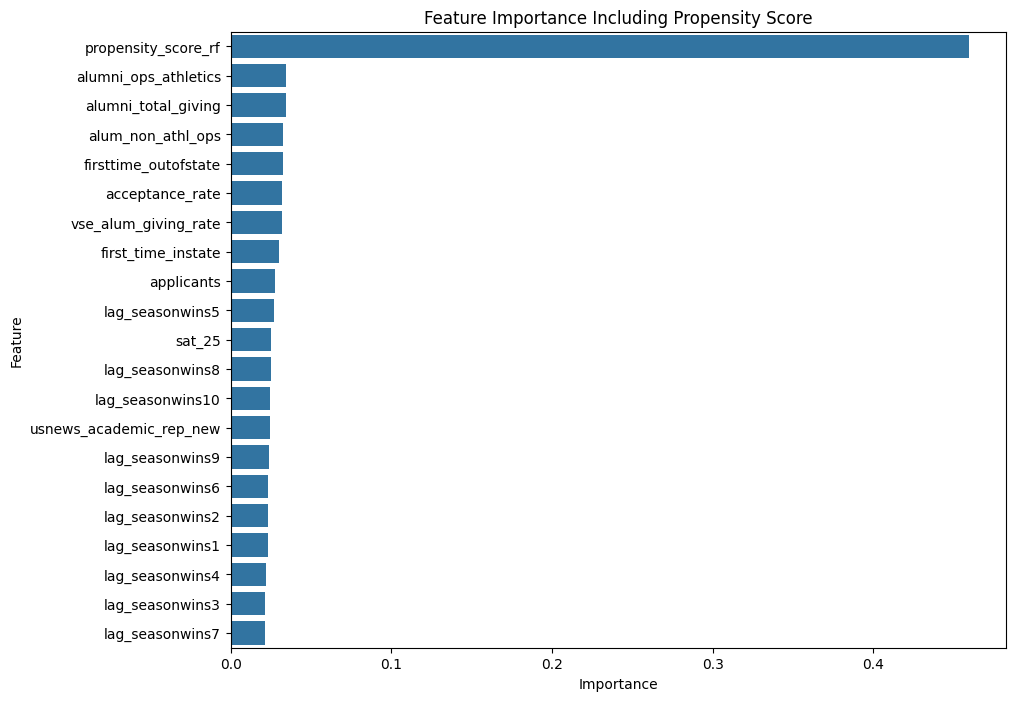

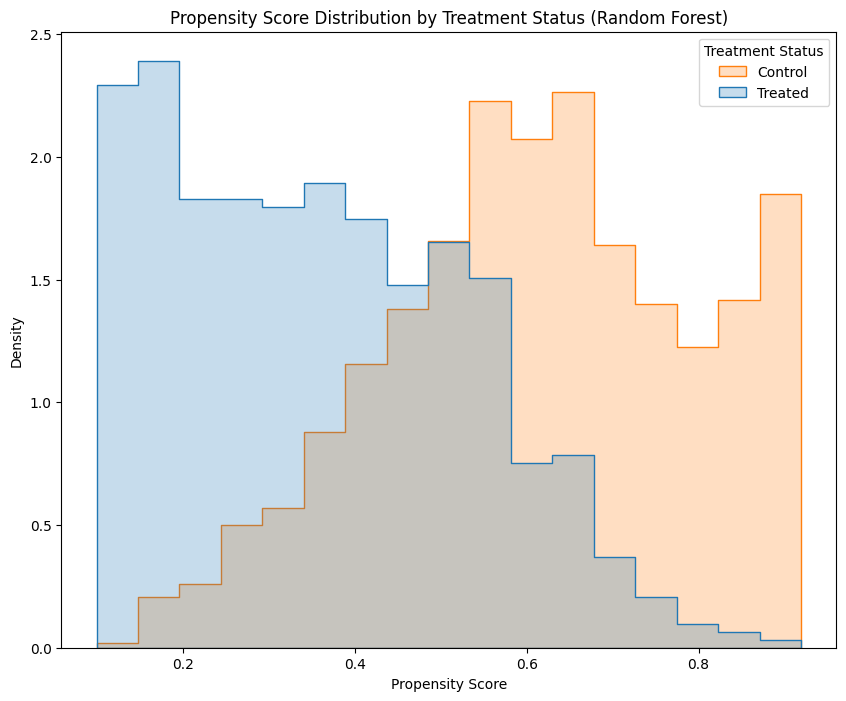

In [ ]:
# Assuming rf is your trained RandomForestRegressor
feature_importance = rf.feature_importances_
important_features = pd.DataFrame({'Feature': covariates, 'Importance': feature_importance})
important_features = important_features.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 8))  # Creates a new figure and sets size
sns.barplot(x='Importance', y='Feature', data=important_features)
plt.title('Feature Importance Including Propensity Score')
plt.savefig('Feature_Importance.png')  # Saves the current figure


# Visualizing the distribution of propensity scores by treatment status
plt.figure(figsize=(10, 8))  # Creates a new figure and sets size
sns.histplot(data=df, x='propensity_score_rf', hue='treated', element='step', stat='density', common_norm=False)
plt.title('Propensity Score Distribution by Treatment Status (Random Forest)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.savefig('propensity_score_distribution_rf.png')  # Saves the current figure

# Calculating summary statistics for Random Forest propensity scores
summary_stats_rf_total = df['propensity_score_rf'].describe()
summary_stats_rf_treated = df[df['treated'] == 1]['propensity_score_rf'].describe()
summary_stats_rf_control = df[df['treated'] == 0]['propensity_score_rf'].describe()

print("Random Forest Propensity Score Summary Statistics - Total:\n", summary_stats_rf_total)
print("Random Forest Propensity Score Summary Statistics - Treated:\n", summary_stats_rf_treated)
print("Random Forest Propensity Score Summary Statistics - Control:\n", summary_stats_rf_control)

# Assuming 'rf' is your trained RandomForestRegressor and 'covariates' are the features used
feature_importance = rf.feature_importances_
important_features = pd.DataFrame({'Feature': covariates, 'Importance': feature_importance})
important_features = important_features.sort_values(by='Importance', ascending=False)

# Displaying the top important features
print("Top Important Features from Random Forest:\n", important_features.head())